# SINKT - Implementação GRU

Este notebook trata da implementação do camada GRU presente no SINKT. Uma espécie de versão otimizada da LSTM, que por sua vez veio para melhorar as RNN. Para realizar tal feito, foi criado um dataset com as seguintes características:
- 10 alunos;
- 5 conceitos;
- 10 questões;
- 50 tentativas p/ cada aluno;

Inicialmente os alunos começam com um domínio baixo do conceito e vão aumentando conforme respondem as questões. Esses valores são distribuídos de forma probabilística, conforme detalhado na seção do Dataset. A tarefa da GRU após treinada, é prever se o aluno vai acertar ou errar a próxima questão, dado o conceito.

##### Funções utils

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_student_concepts(student_data, dependencies, title):
    print(f"Visualizando: {student_data['aluno']}")

    G = nx.DiGraph()
    for concept, parents in dependencies.items():
        score = student_data[concept]
        G.add_node(concept, score=score)
        for parent in parents:
            G.add_edge(parent, concept)

    # Personalized labels
    labels = {}
    for node in G.nodes():
        score = G.nodes[node]['score']
        labels[node] = f"{node}\n{score:.2f}"

    pos = {
        'K1': (0, 1.0),
        'K2': (-0.5, 0.5),
        'K3': (0.5, 0.5),
        'K4': (-0.5, 0.0),
        'K5': (0.5, 0.0)
    }

    node_scores = [nx.get_node_attributes(G, 'score')[node] for node in G.nodes()]

    plt.figure(figsize=(8, 6))

    nx.draw_networkx_nodes(G, pos, 
                        node_color=node_scores, 
                        cmap=plt.cm.RdYlGn, 
                        node_size=2500, 
                        vmin=0.0, vmax=1.0,
                        edgecolors='black')

    nx.draw_networkx_labels(G, pos, 
                            labels=labels,
                            font_color='black', 
                            font_weight='regular',
                            font_size=10)

    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray')

    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Ao invés de utilizar uma função degrau para o fator dos pré-requisitos, optei por utilizar a função logística, pois penaliza de forma mais justa alunos que estão perto do limiar de aceitação e outros que estão mais longe.

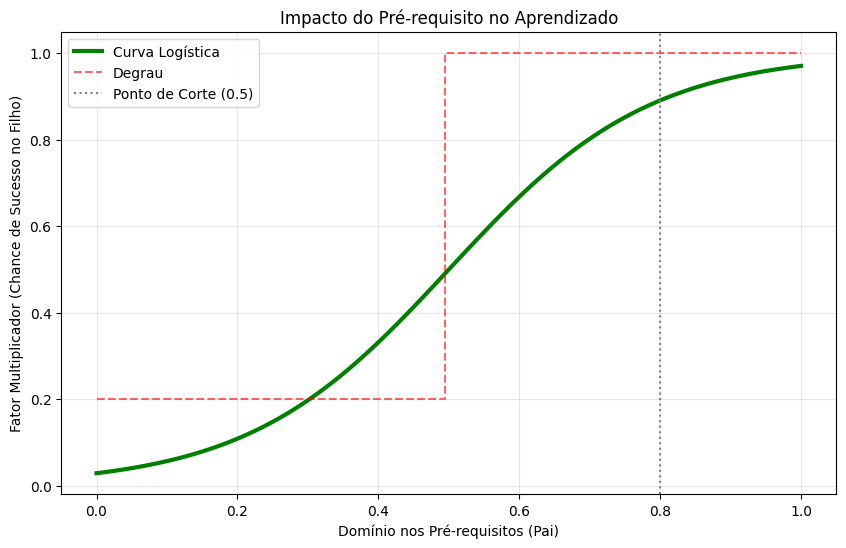

In [2]:
import numpy as np
import matplotlib.pyplot as plt

K = 7
px = 0.8

x = np.linspace(0, 1, 100)

y_logistic = 1 / (1 + np.exp(-K * (x - 0.5)))
y_step = np.where(x < 0.5, 0.2, 1.0)

plt.figure(figsize=(10, 6))

plt.plot(x, y_logistic, label='Curva Logística', color='green', linewidth=3)
plt.step(x, y_step, label='Degrau', color='red', linestyle='--', alpha=0.6)

plt.axvline(px, color='gray', linestyle=':', label=f'Ponto de Corte (0.5)')

plt.title("Impacto do Pré-requisito no Aprendizado")
plt.xlabel("Domínio nos Pré-requisitos (Pai)")
plt.ylabel("Fator Multiplicador (Chance de Sucesso no Filho)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Dataset

Nesta seção será criado o dataset para a aplicação do GRU do SINKT. É constituido por:

Primeiramente é gerado o mapa de conceito dos alunos para cada conceito específico, utilizando fórmulas probabilísticas. A inferência é feita da mesma forma (e ainda considerando se o aluno "chutou" ou teve um "deslize"), usando a tentativa de Bernoulli. Após responder a questão, o aluno aprimora seu domínio em determinado conceito, sendo mais provável de acertar a próxima questão deste mesmo conceito.

<!-- ![Img 1](./imgs/dataset-graph-example-1.png) ![Img 2](./imgs/dataset-graph-example-2.png) -->

<div style="display:flex;">
  <div style="flex: 1; padding: 10px;">
    <img src="./imgs/dataset-graph-example-1.png" alt="Description of image 1" style="width: 100%;">
    <figcaption style="text-align: center;">Exemplo 1</figcaption>
  </div>
  <div style="flex: 1; padding: 10px;">
    <img src="./imgs/dataset-graph-example-2.png" alt="Description of image 2" style="width: 100%;">
    <figcaption style="text-align: center;">Exemplo 2</figcaption>
  </div>
</div>

### Domínio inicial dos alunos ($t_0$)

In [37]:
import pandas as pd
import numpy as np
import random

np.random.seed(41)
random.seed(41)

N_STUDENTS = 10
N_CONCEPTS = 5
N_QUESTIONS = 10
N_ATTEMPTS = 50

Os conceitos são definidos de forma hierarquica:
- $K1$: Aritmética -> Raíz
- $K2$: Álgebra -> Requer $K1$
- $K1$: Geometria -> Requer $K1$
- $K1$: Cálculo -> Requer $K2$
- $K1$: Física -> Requer $K3$ e $K2$

In [38]:
concepts = ['K1', 'K2', 'K3', 'K4', 'K5']

dependencies = {
    'K1': [],
    'K2': ['K1'],
    'K3': ['K1'],
    'K4': ['K2'],
    'K5': ['K2', 'K3']
}

Para cada aluno é atribuído aleatoriamente o conceito $k$. Posteriormente, caso um conceito tenha dependência em outro, é aplicado uma fórmula, baseado na média dos pré-requisitos: 
$$k_i = \overline{D_i}X$$
$$\overline{D_i} = \frac{1}{|D_i|}\sum_{j \in D_i}j $$
- ($0 \leq k_i \leq 1$)
- $D_i$ = valores dos conceitos pré-requisitos de $k_i$
- $X \sim U(a, b) \mid 0 \lt a \lt b \leq 1$

In [39]:
students_ids = [f'Aluno_{i+1}' for i in range(N_STUDENTS)]

student_profiles = {}

for s_id in students_ids:
    profile = {}
    
    profile['K1'] = np.random.uniform(0.1, 1.0)
    profile['K2'] = np.clip(profile['K1'] * np.random.uniform(0.5, 1.0), 0, 1)
    profile['K3'] = np.clip(profile['K1'] * np.random.uniform(0.4, 1.0), 0, 1)
    profile['K4'] = np.clip(profile['K2'] * np.random.uniform(0.3, 1.0), 0, 1)
    # Formula (more than one dependencie)
    avg_parents = (profile['K2'] + profile['K3']) / 2
    profile['K5'] = np.clip(avg_parents * np.random.uniform(0.3, 1.0), 0, 1)
    
    student_profiles[s_id] = profile


pd.DataFrame.from_dict(student_profiles)

,Aluno_1,Aluno_2,Aluno_3,Aluno_4,Aluno_5,Aluno_6,Aluno_7,Aluno_8,Aluno_9,Aluno_10
K1,0.325831,0.643479,0.399034,0.162568,0.647404,0.497498,0.174878,0.352901,0.411960,0.354397
K2,0.170425,0.383170,0.255987,0.138588,0.559505,0.341538,0.098476,0.279185,0.354595,0.323614
K3,0.262649,0.515497,0.204213,0.095721,0.422790,0.373205,0.103831,0.325926,0.252264,0.327684
K4,0.056313,0.361027,0.133619,0.113878,0.322127,0.126376,0.073862,0.238015,0.220728,0.129426
K5,0.082608,0.266520,0.146532,0.067803,0.227183,0.292668,0.101116,0.136955,0.142939,0.161538


### Geração de domínio com base nas respostas ($t_1$ até $t_n$)

Para determinar se um aluno vai acertar ou não, é usado uma fórmula probabilística, baseada nos conceitos do aluno. Além disso é aplicado um ruído $\epsilon$ para simular um "chute" ou "deslize" do aluno, similar ao BKT.
$$\mathbb{P}(\text{acerto}) = k_i  f_i + \epsilon$$
$$f_i = \frac{1}{e^{-10(\overline{D_i}-0.5)}}$$
Resumidamente, a probabilidade do aluno acertar depende do conceito relacionado àquela questões multiplicado pelo seu conceito nos pré-requisitos da mesma (com possível chute ou deslize).

In [40]:
questions_map = {}
for i in range(1, N_QUESTIONS + 1):
    q_id = f'Q{i}'
    concept_idx = (i - 1) % 5 
    questions_map[q_id] = concepts[concept_idx]
questions_map

{'Q1': 'K1',
 'Q2': 'K2',
 'Q3': 'K3',
 'Q4': 'K4',
 'Q5': 'K5',
 'Q6': 'K1',
 'Q7': 'K2',
 'Q8': 'K3',
 'Q9': 'K4',
 'Q10': 'K5'}

In [ ]:
data = []
history_truth = []

LOGISTIC_SLOPE = 10
LOGISTIC_CENTER = 0.6

for student in students_ids:
    for t in range(N_ATTEMPTS):
        question = random.choice(list(questions_map.keys()))
        concept = questions_map[question]
        
        ki = student_profiles[student][concept]
        
        # Check dependencies and calculates fi
        parents = dependencies[concept]
        fi = 1.0
        if parents:
            parents_scores = [student_profiles[student][p] for p in parents]
            avg_parents = np.mean(parents_scores) # Di_bar
            fi = 1 / (1 + np.exp(-LOGISTIC_SLOPE * (avg_parents - LOGISTIC_CENTER))) # Logistic function
        
        prob_success = ki * fi
        
        noise = np.random.normal(0, 0.05)
        final_prob = np.clip(prob_success + noise, 0, 1)
        outcome = 1 if np.random.random() < final_prob else 0 # Bernoulli trial
        
        data.append({
            'aluno': student,
            'tempo': t,
            'conceito': concept,
            'dominio': ki,
            'questao': question,
            'acerto': outcome,
        })
        
        # plot purpose
        snapshot = student_profiles[student].copy()
        snapshot['aluno'] = student
        snapshot['tempo'] = t
        history_truth.append(snapshot)
        
        learning_rate = 0.15 if outcome == 1 else 0.05
        
        new_mastery = ki + learning_rate * (1.0 - ki)
        
        # Clamping (child can't have more than 15% knowledge than paretns)
        if parents:
            max_allowed = avg_parents + 0.15 
            new_mastery = min(new_mastery, max_allowed)
        
        student_profiles[student][concept] = new_mastery

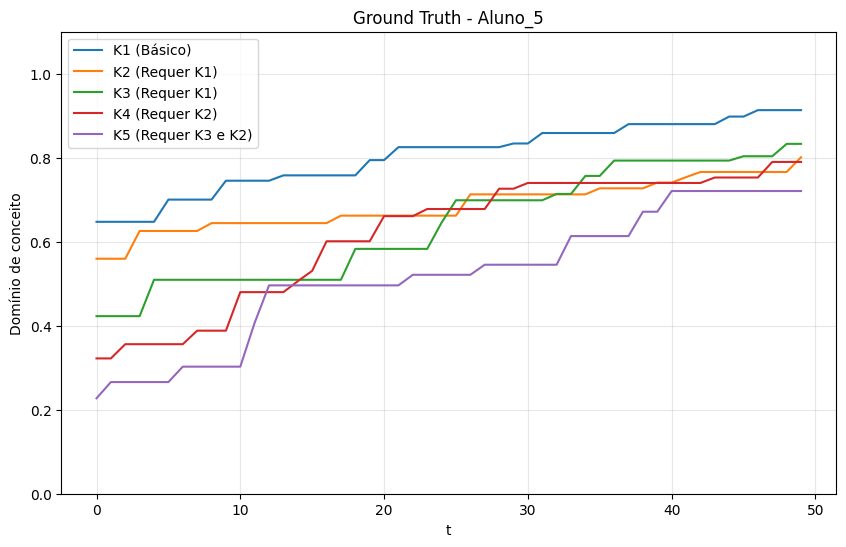

        aluno  tempo conceito  acerto
0     Aluno_1      0       K2       0
1     Aluno_1      1       K1       0
2     Aluno_1      2       K4       0
3     Aluno_1      3       K3       0
4     Aluno_1      4       K2       0
..        ...    ...      ...     ...
495  Aluno_10     45       K3       0
496  Aluno_10     46       K5       1
497  Aluno_10     47       K3       0
498  Aluno_10     48       K1       0
499  Aluno_10     49       K1       0

[500 rows x 4 columns]


In [42]:
df_dynamic = pd.DataFrame(data)
df_history = pd.DataFrame(history_truth)

student_plot = 'Aluno_5'
hist_student = df_history[df_history['aluno'] == student_plot]

plt.figure(figsize=(10, 6))
plt.plot(hist_student['tempo'], hist_student['K1'], label='K1 (Básico)')
plt.plot(hist_student['tempo'], hist_student['K2'], label='K2 (Requer K1)')
plt.plot(hist_student['tempo'], hist_student['K3'], label='K3 (Requer K1)')
plt.plot(hist_student['tempo'], hist_student['K4'], label='K4 (Requer K2)')
plt.plot(hist_student['tempo'], hist_student['K5'], label='K5 (Requer K3 e K2)')

plt.title(f"Ground Truth - {student_plot}")
plt.xlabel("t")
plt.ylabel("Domínio de conceito")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(df_dynamic[['aluno', 'tempo', 'conceito', 'acerto']])

### Visualizando em forma de grafo

Podemos também visualizar em grafo a evolução de determinado aluno.

First index: 50, last index: 79
Visualizando: Aluno_2


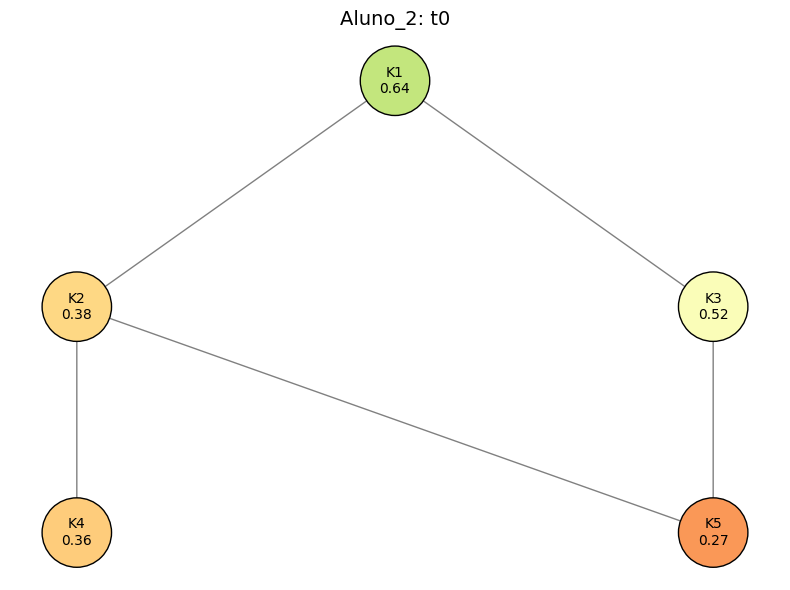

Visualizando: Aluno_2


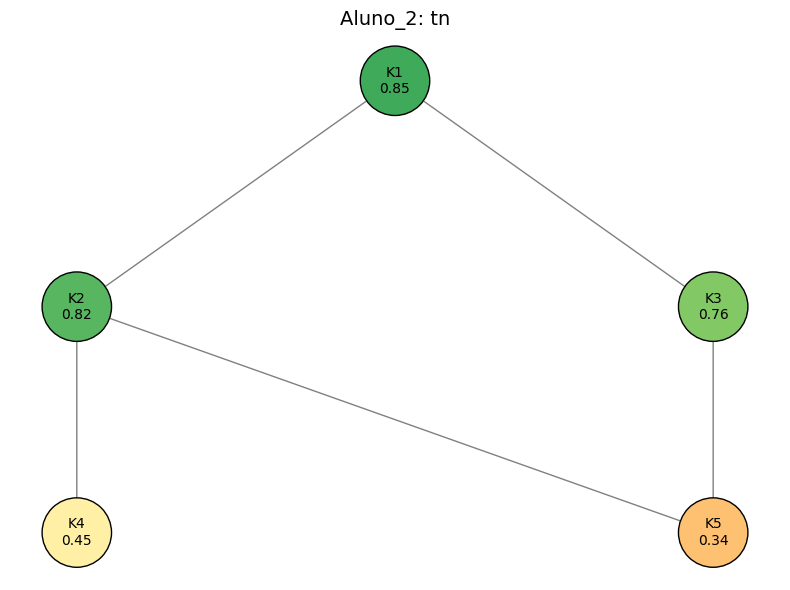

In [86]:
student_id = 'Aluno_2'
idx_first = df_history[(df_history['aluno'] == student_id) &  (df_history['tempo'] == 0)].index[0]
idx_last = df_history[(df_history['aluno'] == student_id) &  (df_history['tempo'] == 29)].index[0]
print(f'First index: {idx_first}, last index: {idx_last}')

data_t0 = df_history.iloc[idx_first].to_dict()
data_t29 = df_history.iloc[idx_last].to_dict()

visualize_student_concepts(data_t0, dependencies, f'{student_id}: t0')
visualize_student_concepts(data_t29, dependencies, f'{student_id}: tn')


## GRU
Com o dataset pronto, agora é hora de utilizarmos o mesmo para treinar o GRU.

In [51]:
df_dynamic.head()

,aluno,tempo,conceito,dominio,questao,acerto
0,Aluno_1,0,K2,0.170425,Q7,0
1,Aluno_1,1,K1,0.325831,Q6,0
2,Aluno_1,2,K4,0.056313,Q4,0
3,Aluno_1,3,K3,0.262649,Q3,0
4,Aluno_1,4,K2,0.211904,Q7,0


Primeiramente os conceitos são mapeados para ids.

In [52]:
df = df_dynamic.copy()
concept_to_id = {c: i for i, c in enumerate(['K1', 'K2', 'K3', 'K4', 'K5'])}
df['concept_id'] = df['conceito'].map(concept_to_id)

Depois é utilizado as respostas em relação ao conceito, de forma a montar sequencias "hot encoded". Essas sequências/vetores tem tamanho $10$ ($5$ primeiras correspondem a valores incorretos e as $5$ últimas valores corretos). Por exemplo:
- Se o aluno **ACERTOU** uma questão do conceito K4 (índice 3), o vetor será: `[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]`.
- Já se o aluno **ERROU** uma questão do conceito K4 (índice 3), o vetor será: `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`.

In [63]:
import torch

input_size = N_CONCEPTS * 2

def prepare_sequences(df):
    sequences = []
    targets = []
    
    concept_map = {'K1': 0, 'K2': 1, 'K3': 2, 'K4': 3, 'K5': 4}
    
    for student_id, group in df.groupby('aluno'):
        group = group.sort_values('tempo')
        
        seq_vectors = []
        target_values = []
        
        for _, row in group.iterrows():
            c_idx = concept_map[row['conceito']]
            answer = row['acerto']
            
            # The input tensor must have 2*N_CONCEPTS size
            # It's a one hot encoded, with the first 5 values being if 
            # the student missed the question concept and other 5
            # in case they were correct
            x = np.zeros(input_size) 
            idx = c_idx + N_CONCEPTS if answer == 1 else c_idx
            x[idx] = 1
            
            seq_vectors.append(x)
            
            target_values.append((c_idx, answer))
            
        sequences.append(seq_vectors)
        targets.append(target_values)
        
    return np.array(sequences), targets

O B (batch) nesse caso é igual a 10, número de alunos e sequência 50, questões respondidas por cada

In [87]:
X_train_raw, y_train_raw = prepare_sequences(df_dynamic)

X_tensor = torch.tensor(X_train_raw, dtype=torch.float32) # (B x seq_len X 10)
print(f"Shape do Tensor de Entrada: {X_tensor.shape}") # array of (c_id, answer 0 or 1)

Shape do Tensor de Entrada: torch.Size([10, 50, 10])


### DKTModel
A implementação utilizando já o módulo do pytorch é bem simples, basta passar o tamanho da entrada e da camada hidden. Como estamos utilizando `BCEWithLogitsLoss`, não precisamos aplicar a função sigmoid na etapa de forward.
- input size: $10$ (vetor `[INCORRETOS | CORRETOS]` que expliquei acima)
- hidden size: $8$

In [68]:
from torch import nn

# Deep Knowledge Tracing
class DKTModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_concepts):
        super(DKTModel, self).__init__()
        # GRU process sequences and update hidden state
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        # Linear layer to decode hidden state into probs
        self.fc = nn.Linear(hidden_size, num_concepts)
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        gru_out, _ = self.gru(x) # out shape: (batch, seq_len, hidden_size)
        logits = self.fc(gru_out)
        # pred = self.sigmoid(logits)
        return logits 

# Instanciando o modelo
HIDDEN_SIZE = 8
model = DKTModel(input_size, HIDDEN_SIZE, N_CONCEPTS)
print(model)

DKTModel(
  (gru): GRU(10, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=5, bias=True)
)


Antes de realizar o treinamento é precisso realizar um pré-processamento: alinhas o input com o output, visto que o modelo tenta prever a resposta em $t_{n+1}$ com o estado em $t_n$.

In [71]:
target_concept_ids = []
target_labels = []

for student_targets in y_train_raw:
    c_ids = [t[0] for t in student_targets] 
    labels = [t[1] for t in student_targets]
    
    target_concept_ids.append(c_ids)
    target_labels.append(labels)

# Inputs: 0 ... t-1. Target: 1 ... t.
# Because the model try to predict the next answer (t+1) based
# on the current state
target_concepts = torch.tensor(target_concept_ids, dtype=torch.int64) 
target_answers = torch.tensor(target_labels, dtype=torch.float32)
print(f'Target concepts shape: ({target_concepts.shape})')
print(f'Target answers shape: ({target_answers.shape})')

# Inputs: (0 .. K-1)
X_input = X_tensor[:, :-1, :] 

# Targets Concept: (1 .. K)
y_concept = target_concepts[:, 1:]

# Targets Answer: (1 .. K)
y_label = target_answers[:, 1:]

print(f"X Input Shape: {X_input.shape}")    # Ex: (B x K-1 x 10)
print(f"Y Concept Shape: {y_concept.shape}") # Ex: (B x K-1)
print(f"Y Label Shape: {y_label.shape}")     # Ex: (B x K-1)

Target concepts shape: (torch.Size([10, 50]))
Target answers shape: (torch.Size([10, 50]))
X Input Shape: torch.Size([10, 49, 10])
Y Concept Shape: torch.Size([10, 49])
Y Label Shape: torch.Size([10, 49])


### Treinamento

Epoch 0 | Loss: 0.6997
Epoch 10 | Loss: 0.5651
Epoch 20 | Loss: 0.5012
Epoch 30 | Loss: 0.4494
Epoch 40 | Loss: 0.3886


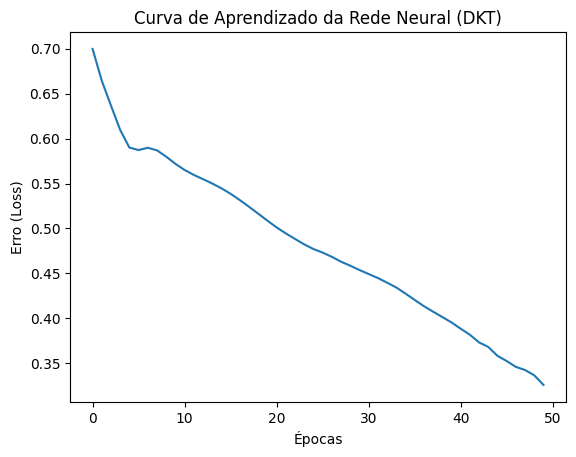

In [82]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

epochs = 50
loss_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    logits = model(X_tensor) # (B x Seq_len X 5)
    gather_idx = y_concept.unsqueeze(-1) # (B x K-1) -> (B x K-1 x 1)
    selected_logits = logits.gather(2, gather_idx)

    selected_logits = selected_logits.squeeze(-1) # (B x K-1)

    loss = criterion(selected_logits, y_label)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Visualizar Queda da Loss
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.title("Curva de Aprendizado da Rede Neural (DKT)")
plt.xlabel("Épocas")
plt.ylabel("Erro (Loss)")
plt.show()

In [84]:
model.eval()
with torch.no_grad():
    logits_output = model(X_input[0:1]) # First student
    probs_output = torch.sigmoid(logits_output)
    next_step_probs = probs_output[0, -1, :]

print("Probabilidades Reais para a Próxima Questão:")
print(next_step_probs) # Valores entre 0 e 1

Probabilidades Reais para a Próxima Questão:
tensor([0.9420, 0.7465, 0.6539, 0.4366, 0.3470])


Caso fossemos usar um *threshold* de $0.7$, o aluno acertaria apenas $K1$ e $K2$.